In [1]:
from livelossplot import PlotLossesKeras

In [2]:
!pip install scikeras

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, r2_score
import os
from dotenv import load_dotenv
import yfinance as yf
import pandas as pd
import pandas_ta as ta
from scikeras.wrappers import KerasRegressor
# Load environment variables from the .env file
load_dotenv('../.env');

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter
from calendar import monthrange
from calendar import month_name

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

[*********************100%%**********************]  1 of 1 completed


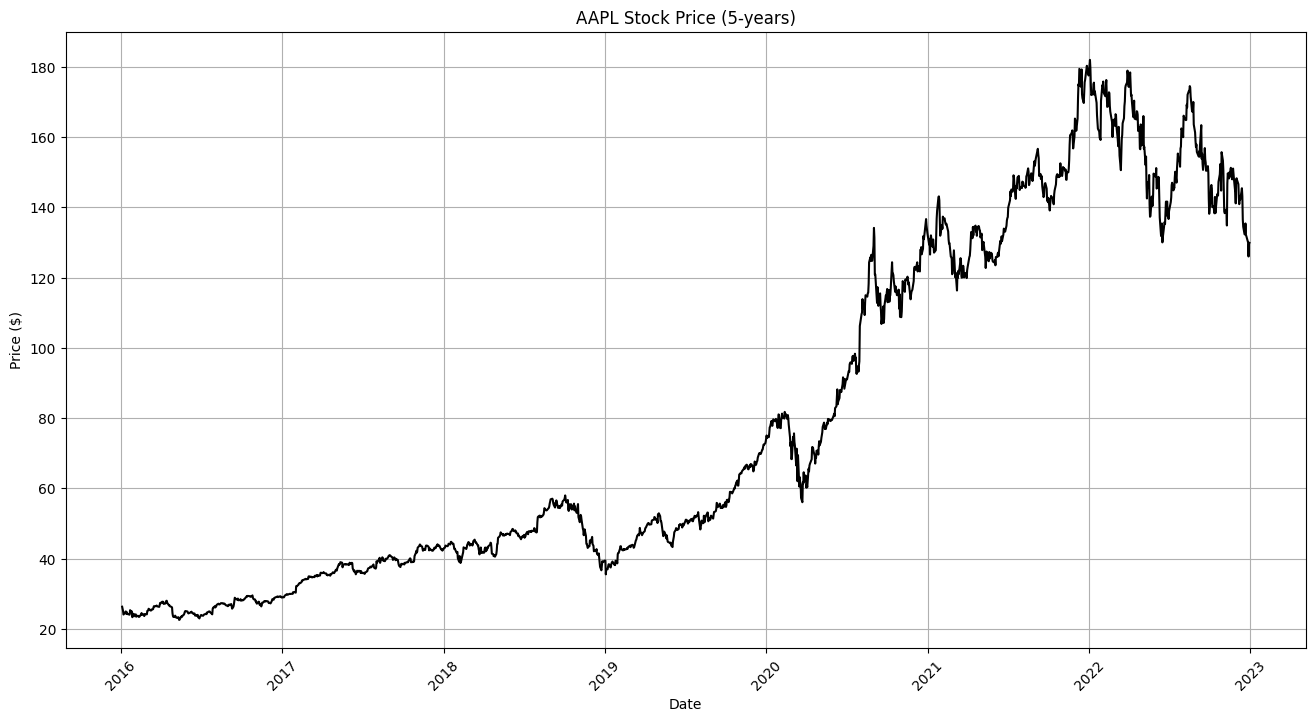

In [45]:
data = yf.download('AAPL', start='2016-01-01', end='2022-12-31')
# Plot the close price
plt.figure(figsize=(16,8))
plt.plot(data['Close'], color='black')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Price ($)')
plt.title('AAPL Stock Price (5-years)')
plt.grid(True)
plt.show()

In [38]:
# Specify the stock symbol and the date range
stock_symbol = "AAPL"
start_date = "2013-01-01"
end_date = "2023-12-18"

# Fetch the stock data
apple_cl = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the stock data
apple_cl.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.769098,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.557430,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.096233,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.001535,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.044611,458707200


In [39]:
#here we are adding technical indicators to the data set as seperate columns

apple_cl['RSI'] = ta.rsi(apple_cl['Adj Close'], length=15)
apple_cl['EMAF'] = ta.ema(apple_cl['Adj Close'], length=20) #fast moving avg
apple_cl['EMAM'] = ta.ema(apple_cl['Adj Close'], length=100) #medium moving avg
apple_cl['EMAS'] = ta.ema(apple_cl['Adj Close'], length=150) #slow moving avg


apple_cl['target'] = apple_cl['Adj Close'] - apple_cl.Open
apple_cl['target'] = apple_cl['target'].shift(-1)
apple_cl['target_class'] = [1 if apple_cl.target[i]>0 else 0 for i in range(len(apple_cl))]
apple_cl['target_next_close'] = apple_cl['Adj Close'].shift(-1)

apple_cl.dropna(inplace=True)
apple_cl.reset_index(inplace=True)
apple_cl.drop(['Volume' , 'Close', 'Date'], axis=1, inplace=True)


C:\Users\chris\AppData\Local\Temp\ipykernel_18452\4218335423.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  apple_cl['target_class'] = [1 if apple_cl.target[i]>0 else 0 for i in range(len(apple_cl))]


In [40]:
apple_cl.head()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,target,target_class,target_next_close
0,16.715000,16.853214,16.506071,14.387617,69.082159,13.722881,13.575871,13.709909,-2.185020,0,14.379265
1,16.564285,16.678572,16.491785,14.379265,68.808369,13.785394,13.591779,13.718775,-2.215801,0,14.350628
2,16.566429,16.575001,16.355356,14.350628,67.820953,13.839226,13.606806,13.727144,-2.233579,0,14.146420
3,16.379999,16.445000,16.201786,14.146420,61.119810,13.868482,13.617491,13.732697,-1.768133,0,14.548296
4,16.316429,16.737499,16.308214,14.548296,67.823412,13.933226,13.635923,13.743500,-1.579622,0,15.239664


In [41]:
# Stock closing prices are features and date is the date time index

numeric_features = apple_cl[['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMAF', 'EMAS', 'EMAM']]
targets = apple_cl[['target', 'target_class', 'target_next_close']]

train_size = int(len(apple_cl) * 0.8)
train_features, test_features = numeric_features[:train_size], numeric_features[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]


# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler(feature_range=(0,1)))
])

# Apply the preprocessing pipeline to numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing_pipeline, numeric_features.columns)
    ])

In [42]:
# Fit and transform the training data
train_features_preprocessed = preprocessor.fit_transform(train_features)

# Transform the test data using the learned parameters from the training data
test_features_preprocessed = preprocessor.transform(test_features)

### Reshape the Data

In [10]:
def reshape_for_lstm(data, time_steps):
    return data.reshape((data.shape[0], time_steps, data.shape[1]))

time_steps = 1  # We can experiment with different time steps
train_features_lstm = reshape_for_lstm(train_features_preprocessed, time_steps)
test_features_lstm = reshape_for_lstm(test_features_preprocessed, time_steps)


### Build The Model

In [11]:
model = Sequential()
time_steps = 1
model.add(LSTM(units=50, activation='relu', input_shape=(time_steps, numeric_features.shape[1])))
model.add(Dense(units=3))  # Assuming you have 3 output columns

model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust the loss function based on your problem

### Train the model

In [13]:
epochs = 50
batch_size = 32

In [14]:
model.fit(train_features_lstm, train_targets, epochs=epochs, batch_size=batch_size)


Epoch 1/50

66/66 [==============================] - 1s 1ms/step - loss: 5317.9697
Epoch 2/50
66/66 [==============================] - 0s 1ms/step - loss: 5225.5669
Epoch 3/50
66/66 [==============================] - 0s 1ms/step - loss: 4982.2026
Epoch 4/50
66/66 [==============================] - 0s 1ms/step - loss: 4560.7217
Epoch 5/50
66/66 [==============================] - 0s 1ms/step - loss: 4004.7266
Epoch 6/50
66/66 [==============================] - 0s 1ms/step - loss: 3380.4634
Epoch 7/50
66/66 [==============================] - 0s 1ms/step - loss: 2737.7473
Epoch 8/50
66/66 [==============================] - 0s 1ms/step - loss: 2124.1218
Epoch 9/50
66/66 [==============================] - 0s 1ms/step - loss: 1574.7340
Epoch 10/50
66/66 [==============================] - 0s 1ms/step - loss: 1120.6440
Epoch 11/50
66/66 [==============================] - 0s 1ms/step - loss: 757.8773
Epoch 12/50
66/66 [==============================] - 0s 1ms/step - loss: 491.5757
Epoch 13/50
66

In [16]:
test_loss = model.evaluate(test_features_lstm, test_targets)
print(f'Test Loss: {test_loss}')

17/17 [==============================] - 0s 1ms/step - loss: 36.6233
Test Loss: 36.62326431274414


17/17 [==============================] - 0s 961us/step


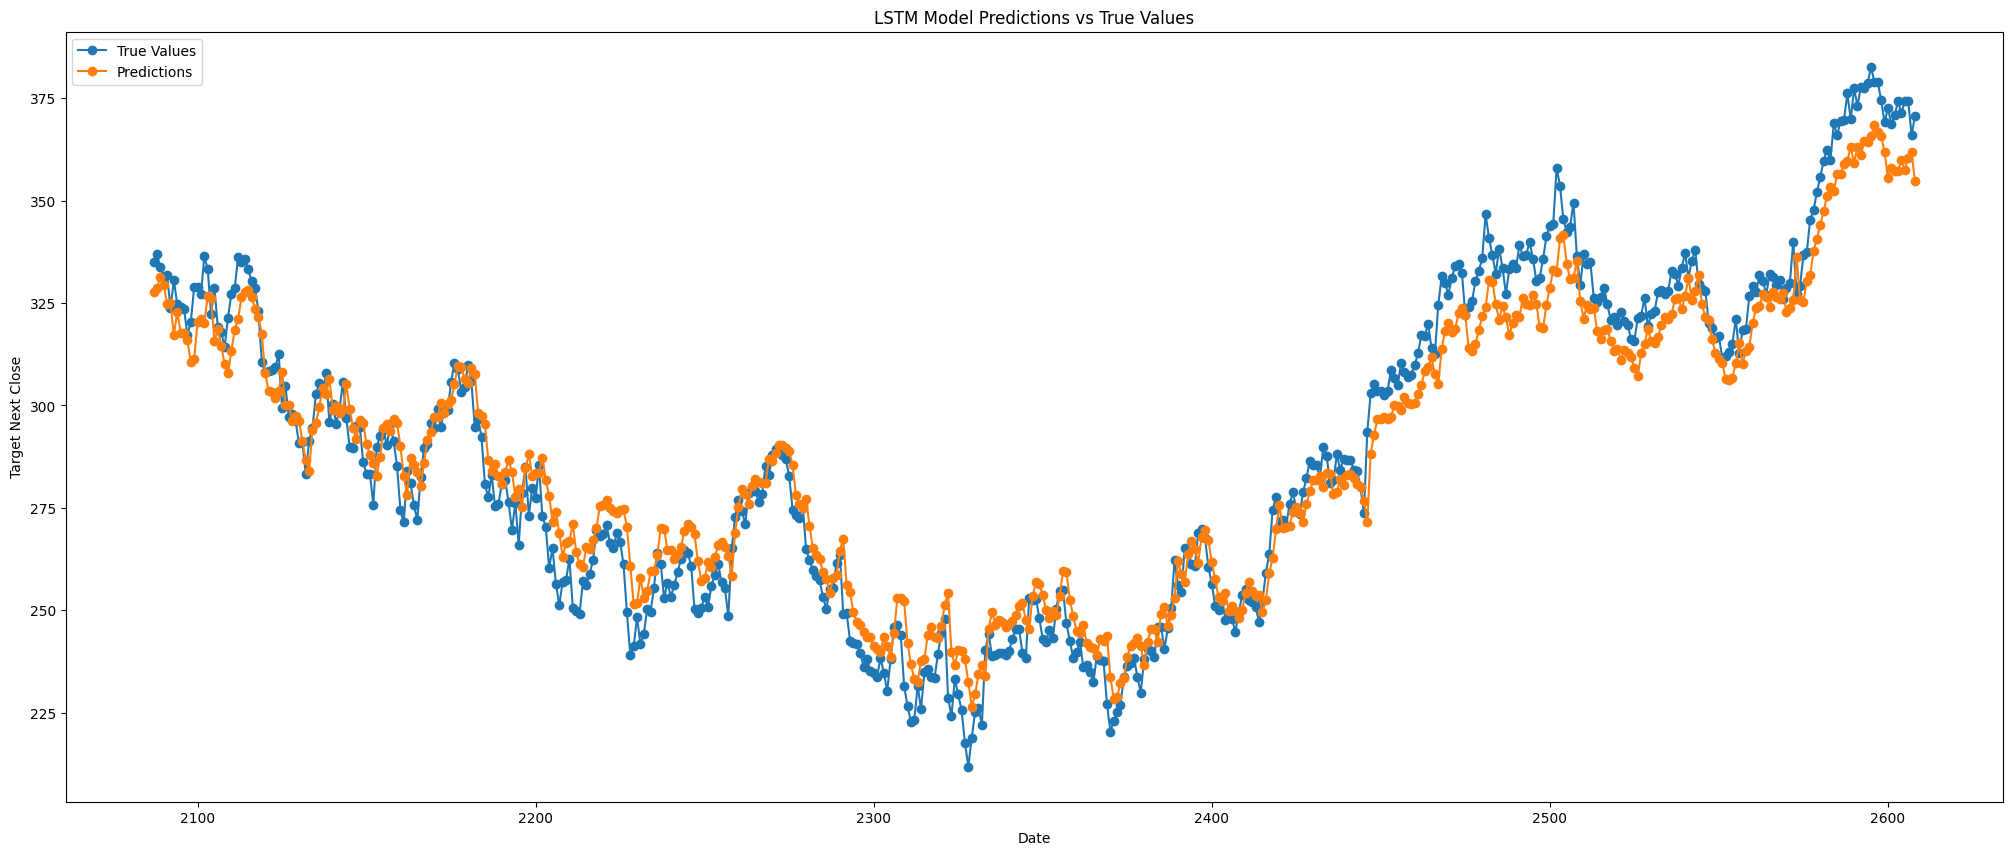

In [17]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained LSTM model
predictions = model.predict(test_features_lstm)

# Plotting
plt.figure(figsize=(25, 10))
plt.plot(test_targets.index, test_targets['target_next_close'], label='True Values', marker='o')
plt.plot(test_targets.index, predictions[:, 2], label='Predictions', marker='o')  # Assuming 'target_next_close' is the third column
plt.title('LSTM Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Target Next Close')
plt.legend()
plt.show()


Epoch 1/50
66/66 [==============================] - 0s 2ms/step - loss: 2.6978 - val_loss: 36.2611
Epoch 2/50
66/66 [==============================] - 0s 2ms/step - loss: 2.6747 - val_loss: 35.8891
Epoch 3/50
66/66 [==============================] - 0s 2ms/step - loss: 2.6796 - val_loss: 35.9302
Epoch 4/50
66/66 [==============================] - 0s 2ms/step - loss: 2.6851 - val_loss: 37.6041
Epoch 5/50
66/66 [==============================] - 0s 3ms/step - loss: 2.6739 - val_loss: 35.7941
Epoch 6/50
66/66 [==============================] - 0s 2ms/step - loss: 2.6690 - val_loss: 36.0231
Epoch 7/50
66/66 [==============================] - 0s 2ms/step - loss: 2.6588 - val_loss: 36.6340
Epoch 8/50
66/66 [==============================] - 0s 2ms/step - loss: 2.6755 - val_loss: 35.2490
Epoch 9/50
66/66 [==============================] - 0s 2ms/step - loss: 2.6328 - val_loss: 35.9137
Epoch 10/50
66/66 [==============================] - 0s 2ms/step - loss: 2.6572 - val_loss: 34.7248
Epoch 11/

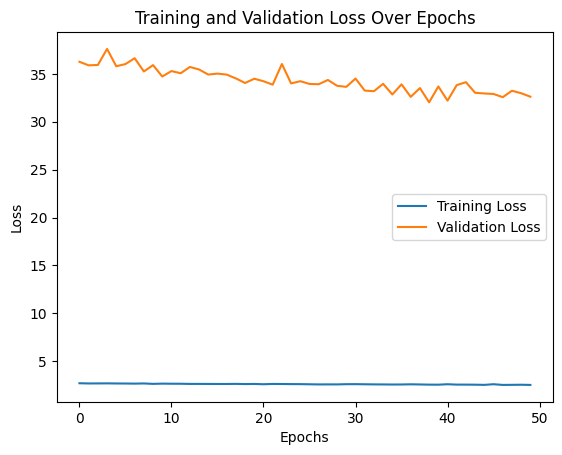

In [20]:
history = model.fit(train_features_lstm, train_targets, epochs=epochs, batch_size=batch_size, validation_data=(test_features_lstm, test_targets))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = model.predict(test_features_lstm)
mae = mean_absolute_error(test_targets['target_next_close'], predictions[:, 2])  # Assuming 'target_next_close' is the third column
mse = mean_squared_error(test_targets['target_next_close'], predictions[:, 2])
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

17/17 [==============================] - 0s 1ms/step
MAE: 129.28
MSE: 17157.77
RMSE: 130.99


In [49]:
from sklearn.metrics import accuracy_score

# Assuming 'target_class' is the classification target column
predictions_class = (predictions[:, 1] > 0.5).astype(int)
accuracy = accuracy_score(test_targets['target_class'], predictions_class)

print(f'Directional Accuracy: {accuracy:.2%}')

Directional Accuracy: 59.20%


In [54]:
x1 = np.arange(0, len(train_targets))
x2 = np.arange(len(train_targets), len(train_targets)+len(test_targets))

In [ ]:
plt.plot(x1,train_targets)
plt.plot(x1,train_predicted)
plt.plot(x2,test_actual)
plt.plot(x2,test_predicted)
plt.legend(['train_actual','train_predicted','test_actual','test_predicted'])
plt.vlines(x=int(len(train_actual)), color='r',linestyles='dashed', ymin = 0, ymax = max(test_actual))
plt.show()

### Grid Search 

In [22]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [23]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam

# Function to create an LSTM model
def create_lstm_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(time_steps, numeric_features.shape[1])))
    model.add(Dense(units=3))  # Assuming you have 3 output columns
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the Keras model for use with GridSearchCV
lstm_regressor = KerasRegressor(learning_rate=0.001,build_fn=create_lstm_model, epochs=10, batch_size=32, units=50, verbose=0)

# Define hyperparameters to search
param_grid = {
    'units': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')



In [24]:
grid_result = grid_search.fit(train_features_lstm, train_targets)

C:\Users\chris\Documents\1_spicy\000_datadrivendollars\ds-capstone\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\chris\Documents\1_spicy\000_datadrivendollars\ds-capstone\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\chris\Documents\1_spicy\000_datadrivendollars\ds-capstone\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\chris\Documents\1_spicy\000_datadrivendollars\ds-capstone\.venv\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``b

In [25]:
grid_search

GridSearchCV(cv=3,
             estimator=KerasRegressor(batch_size=32, build_fn=<function create_lstm_model at 0x0000018A33EE2160>, epochs=10, learning_rate=0.001, units=50, verbose=0),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'units': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [26]:
best_params = grid_result.best_params_


In [27]:
best_model = create_lstm_model(units=best_params['units'], learning_rate=best_params['learning_rate'])


In [28]:
best_params

{'learning_rate': 0.01, 'units': 150}

In [29]:
best_model.fit(train_features_lstm, train_targets, epochs=epochs, batch_size=batch_size, verbose=1)


Epoch 1/50
66/66 [==============================] - 1s 2ms/step - loss: 2979.1650
Epoch 2/50
66/66 [==============================] - 0s 2ms/step - loss: 27.3199
Epoch 3/50
66/66 [==============================] - 0s 1ms/step - loss: 11.4157
Epoch 4/50
66/66 [==============================] - 0s 1ms/step - loss: 9.8590
Epoch 5/50
66/66 [==============================] - 0s 1ms/step - loss: 8.4723
Epoch 6/50
66/66 [==============================] - 0s 2ms/step - loss: 7.2641
Epoch 7/50
66/66 [==============================] - 0s 2ms/step - loss: 6.3567
Epoch 8/50
66/66 [==============================] - 0s 2ms/step - loss: 5.6332
Epoch 9/50
66/66 [==============================] - 0s 2ms/step - loss: 5.1562
Epoch 10/50
66/66 [==============================] - 0s 2ms/step - loss: 4.8136
Epoch 11/50
66/66 [==============================] - 0s 2ms/step - loss: 4.5102
Epoch 12/50
66/66 [==============================] - 0s 2ms/step - loss: 4.1623
Epoch 13/50
66/66 [=========================

In [30]:
print("Best mean squared error found: ", -grid_result.best_score_)

Best mean squared error found:  9.006579568974736


In [31]:
grid_result

GridSearchCV(cv=3,
             estimator=KerasRegressor(batch_size=32, build_fn=<function create_lstm_model at 0x0000018A33EE2160>, epochs=10, learning_rate=0.001, units=50, verbose=0),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'units': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [32]:
y_pred = grid_result.predict(test_features_lstm)
print("Mean Squared Error on test set: ", mean_squared_error(test_targets, y_pred))
print("R-squared on test set: ", r2_score(test_targets, y_pred))

Mean Squared Error on test set:  36.94076236803778
R-squared on test set:  0.08789770423740473


In [33]:
best_model.save_weights("model_ttest.h5")

In [34]:
best_model.save("model_ttest_v2.h5")


C:\Users\chris\Documents\1_spicy\000_datadrivendollars\ds-capstone\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
best_model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 150)               95400     
                                                                 
 dense_29 (Dense)            (None, 3)                 453       
                                                                 
Total params: 95853 (374.43 KB)
Trainable params: 95853 (374.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
